In [46]:
#dataset: https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

# Faster RCNN 
# Mask RCNN

In [4]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvisutils import engine, utils
from easyimages import EasyImageList
from easyimages.utils import vis_image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvisutils.engine import train_one_epoch, evaluate
from torchvisutils import utils
import torchvisutils.transforms as T
import itertools
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
def get_fpn_predictions(model, images, targets):

    device = 'cuda'
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    images, targets = model.transform(images, targets)

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([('0', features)])
    boxes, losses = model.rpn(images, features, targets)
    
    return boxes, losses
    
ds = '/home/i008/PennFudanPed'
dataset = PennFudanDataset(ds)
dataset[0][0]

# use our dataset and defined transformations
dataset = PennFudanDataset(ds, get_transform(train=True))
dataset_test = PennFudanDataset(ds, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [5]:

def get_instance_segmentation_model(num_classes, pretrained=True):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

it = iter(data_loader_test)
index = 10
images, targets = next(itertools.islice(it, index, None))

In [6]:
def get_fpn_predictions(model, images, targets):

    device = 'cuda'
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    images, targets = model.transform(images, targets)

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([('0', features)])
    boxes, losses = model.rpn(images, features, targets)
    
    return boxes, losses, images


# visualize FPN outputs for a pretrained/not pretrained network network

In [11]:
model_pretrained = get_instance_segmentation_model(2, pretrained=True)
model_pretrained.eval()

boxes, losses, tr_images = get_fpn_predictions(model_pretrained.cuda(), images, targets)
img = np.moveaxis(invTrans(tr_images.tensors[0]).cpu().numpy(), 0, 2)
f = vis_image(img,boxes=[b.cpu().numpy() for b in boxes[0]][:30], 
          box_order='tlbr')

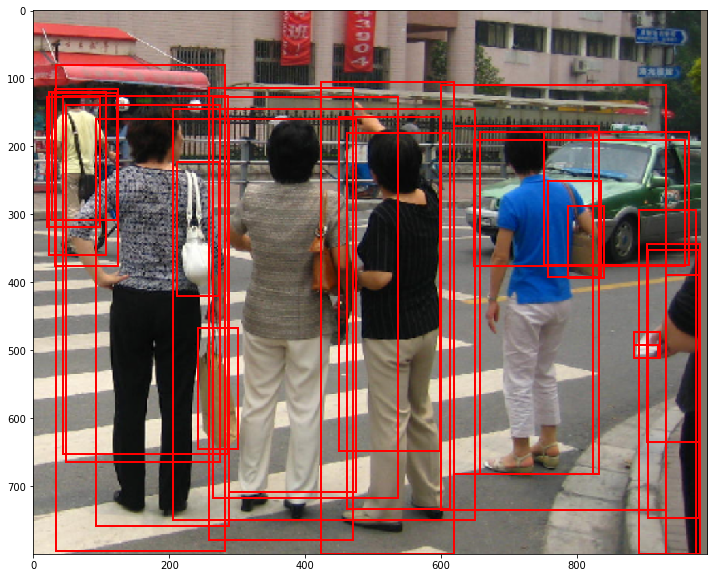

In [12]:
f

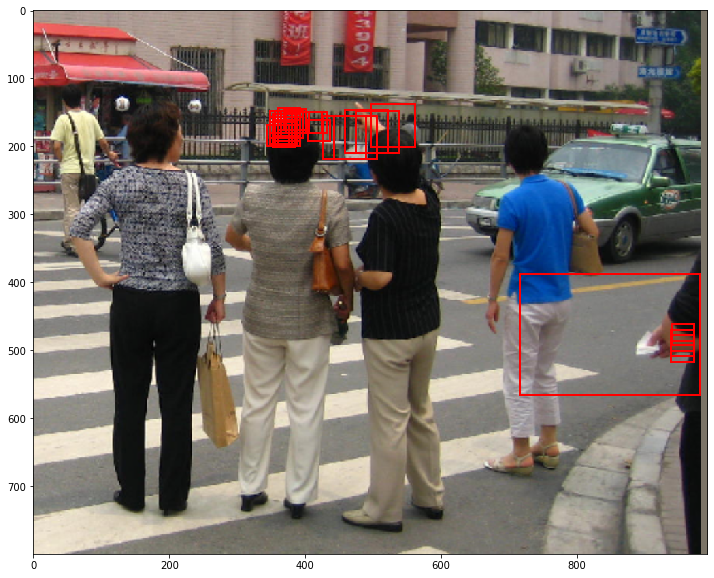

In [8]:
model_not_pretrained = get_instance_segmentation_model(2, pretrained=False)
model_not_pretrained.eval()
boxes, losses, tr_images = get_fpn_predictions(model_not_pretrained.cuda(), images, targets)
img = np.moveaxis(invTrans(tr_images.tensors[0]).cpu().numpy(), 0, 2)
f = vis_image(
    img,boxes=[b.cpu().numpy() for b in boxes[0]][:30], 
    box_order='tlbr')

In [275]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes, pretrained=True)
# move model to the right device
model.to(device)
model.train()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [276]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/120]  eta: 0:00:55  lr: 0.000047  loss: 8.0977 (8.0977)  loss_classifier: 0.7921 (0.7921)  loss_box_reg: 0.0666 (0.0666)  loss_mask: 7.2228 (7.2228)  loss_objectness: 0.0113 (0.0113)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 0.4647  data: 0.1534  max mem: 5855
Epoch: [0]  [ 10/120]  eta: 0:00:34  lr: 0.000467  loss: 3.4881 (4.0419)  loss_classifier: 0.5303 (0.5231)  loss_box_reg: 0.1384 (0.1629)  loss_mask: 2.8741 (3.3248)  loss_objectness: 0.0115 (0.0185)  loss_rpn_box_reg: 0.0151 (0.0125)  time: 0.3137  data: 0.0156  max mem: 5872
Epoch: [0]  [ 20/120]  eta: 0:00:30  lr: 0.000886  loss: 0.7828 (2.3890)  loss_classifier: 0.2364 (0.3434)  loss_box_reg: 0.1379 (0.1462)  loss_mask: 0.3295 (1.8669)  loss_objectness: 0.0142 (0.0212)  loss_rpn_box_reg: 0.0101 (0.0112)  time: 0.2952  data: 0.0022  max mem: 5872
Epoch: [0]  [ 30/120]  eta: 0:00:26  lr: 0.001306  loss: 0.4631 (1.7626)  loss_classifier: 0.0945 (0.2641)  loss_box_reg: 0.0905 (0.1290)  loss_mask: 0.2396 (1.3396) 

Epoch: [1]  [ 80/120]  eta: 0:00:11  lr: 0.005000  loss: 0.1979 (0.2181)  loss_classifier: 0.0242 (0.0318)  loss_box_reg: 0.0182 (0.0212)  loss_mask: 0.1448 (0.1505)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0080 (0.0131)  time: 0.2882  data: 0.0025  max mem: 5995
Epoch: [1]  [ 90/120]  eta: 0:00:08  lr: 0.005000  loss: 0.2235 (0.2232)  loss_classifier: 0.0242 (0.0321)  loss_box_reg: 0.0165 (0.0218)  loss_mask: 0.1573 (0.1546)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0093 (0.0129)  time: 0.2814  data: 0.0025  max mem: 5995
Epoch: [1]  [100/120]  eta: 0:00:05  lr: 0.005000  loss: 0.2027 (0.2219)  loss_classifier: 0.0320 (0.0324)  loss_box_reg: 0.0136 (0.0212)  loss_mask: 0.1376 (0.1536)  loss_objectness: 0.0009 (0.0018)  loss_rpn_box_reg: 0.0086 (0.0128)  time: 0.2879  data: 0.0025  max mem: 5995
Epoch: [1]  [110/120]  eta: 0:00:02  lr: 0.005000  loss: 0.1965 (0.2199)  loss_classifier: 0.0321 (0.0327)  loss_box_reg: 0.0104 (0.0206)  loss_mask: 0.1294 (0.1523) 

Epoch: [3]  [  0/120]  eta: 0:00:48  lr: 0.000500  loss: 0.1175 (0.1175)  loss_classifier: 0.0092 (0.0092)  loss_box_reg: 0.0072 (0.0072)  loss_mask: 0.0957 (0.0957)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 0.4062  data: 0.1397  max mem: 5995
Epoch: [3]  [ 10/120]  eta: 0:00:34  lr: 0.000500  loss: 0.1371 (0.1496)  loss_classifier: 0.0171 (0.0242)  loss_box_reg: 0.0070 (0.0102)  loss_mask: 0.0957 (0.1038)  loss_objectness: 0.0004 (0.0005)  loss_rpn_box_reg: 0.0087 (0.0109)  time: 0.3113  data: 0.0147  max mem: 5995
Epoch: [3]  [ 20/120]  eta: 0:00:30  lr: 0.000500  loss: 0.1400 (0.1510)  loss_classifier: 0.0172 (0.0227)  loss_box_reg: 0.0070 (0.0097)  loss_mask: 0.1014 (0.1084)  loss_objectness: 0.0006 (0.0008)  loss_rpn_box_reg: 0.0087 (0.0095)  time: 0.2996  data: 0.0023  max mem: 5995
Epoch: [3]  [ 30/120]  eta: 0:00:27  lr: 0.000500  loss: 0.1400 (0.1468)  loss_classifier: 0.0123 (0.0205)  loss_box_reg: 0.0054 (0.0088)  loss_mask: 0.1071 (0.1078) 

Epoch: [4]  [ 80/120]  eta: 0:00:11  lr: 0.000500  loss: 0.1168 (0.1427)  loss_classifier: 0.0155 (0.0189)  loss_box_reg: 0.0045 (0.0075)  loss_mask: 0.0966 (0.1076)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0028 (0.0076)  time: 0.2906  data: 0.0025  max mem: 5995
Epoch: [4]  [ 90/120]  eta: 0:00:08  lr: 0.000500  loss: 0.1500 (0.1462)  loss_classifier: 0.0169 (0.0194)  loss_box_reg: 0.0045 (0.0081)  loss_mask: 0.1134 (0.1098)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0059 (0.0077)  time: 0.2834  data: 0.0025  max mem: 5995
Epoch: [4]  [100/120]  eta: 0:00:05  lr: 0.000500  loss: 0.1441 (0.1475)  loss_classifier: 0.0217 (0.0200)  loss_box_reg: 0.0068 (0.0082)  loss_mask: 0.1134 (0.1103)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0062 (0.0077)  time: 0.2925  data: 0.0025  max mem: 5995
Epoch: [4]  [110/120]  eta: 0:00:02  lr: 0.000500  loss: 0.1434 (0.1478)  loss_classifier: 0.0193 (0.0198)  loss_box_reg: 0.0056 (0.0081)  loss_mask: 0.1055 (0.1111) 

Exception ignored in: <function _releaseLock at 0x7f004ea21560>
Traceback (most recent call last):
  File "/home/i008/anaconda3/envs/dl/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 13541) exited unexpectedly

In [277]:
# pick one image from the test set
img, _ = dataset_test[3]
# put the model in evaluation mode


In [278]:
model.eval()
predictions = model([images[0].cuda()])

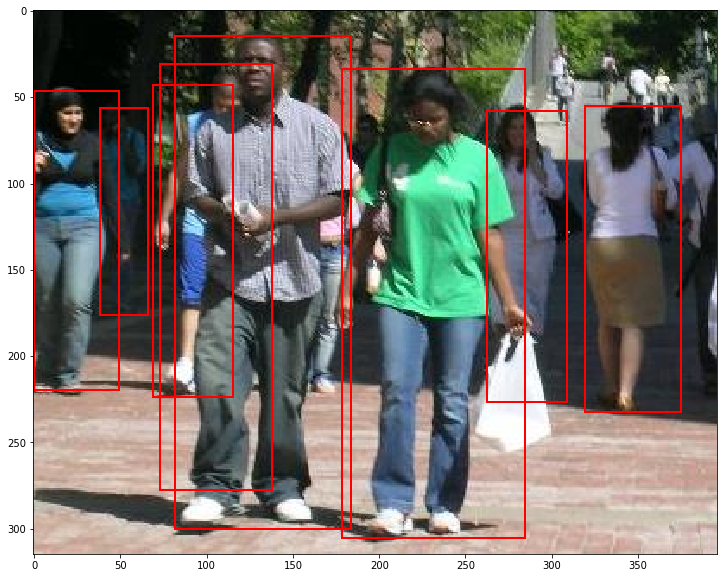

In [279]:
f = vis_image(img, prediction[0]['boxes'][:500])

In [ ]:
# 100 images persons, cars

i1.jpg, 'car', 10,10,20,20 (x1,y1,x2,y2)
i1.jpg, 'person', 32, 45, 19, 20 
i1.jpg, 'car', 100,100,200,200


In [9]:
anchorbox_1 wiht ground_truth_box_N ==  0.4<iou<0.5  -> -1
anchorbox_1 wiht ground_truth_box_N > 0.5  -> 1
anchorbox_1 wiht ground_truth_box_N < 0.4  -> 0


SyntaxError: invalid syntax (<ipython-input-9-ba86383b115e>, line 1)